# Intro to Data Mining Project
Members:
- Oscar
- Richard
- John
- Cristian

Focus:
>trying to find features that lead to high scoring anime. will also try to predict popular anime for the current season

## Libraries used
self explanatory


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from time import strptime
from sklearn import preprocessing
from sklearn.tree import plot_tree
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)

In [2]:
df = pd.read_csv('anime.csv')

## Data Prep/Cleaning

### checking unkowns and dropping columns
checking kaggle dataset to make sure nothing occurs

In [3]:
# check for missing values for each feature
num_missing = (df[['MAL_ID','Name','Score','English name','Japanese name','Episodes','Genres','Type','Aired','Premiered','Producers','Licensors','Studios','Ranked','Popularity','Members','Favorites','Watching','Completed','On-Hold','Dropped','Plan to Watch','Score-10','Score-9','Score-8','Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1']] == 'Unknown').sum()
# print(num_missing)

# drop columns that are not useful to us
df = df.drop(columns=['English name', 'Japanese name','Episodes','Licensors','Score-10','Score-9','Score-8','Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1','Source', 'Duration'])

df.to_csv('anime2.csv', index = False)

out = pd.read_csv('anime2.csv')
# print(out)

num_missing = (out[['MAL_ID','Name','Score','Genres','Type','Aired','Premiered','Producers','Studios','Ranked','Popularity','Members','Favorites','Watching','Completed','On-Hold','Dropped','Plan to Watch']] == 'Unknown').sum()
# print(num_missing)
# fixing score column
df['Score'] = df['Score'].replace(['Unknown'],0.0)

### adding types and making strings more uniform to kaggle dataset
this pertains to text mined data
*   adding type of media it is
*   reformatting columns to be long strings

In [4]:
# Modifying new anime CSV to play more nicely with original dataset
new_season = pd.read_csv("anime_2022_2.csv")
# adding Type to new_season csv
new_season["Type"] = "TV"
for i in range(75, 97):
    new_season.iat[i, 7] = "ONA"

new_season.iat[96, 7] = "OVA"
new_season.iat[97, 7] = "OVA"

for i in range(98, 117):
    new_season.iat[i, 7] = "Movie"

# Doing some cleaning to new_season
new_genre_format = []
for i, row in new_season.iterrows():
    scuffedG = row[3]
    betterG = scuffedG.replace("[","").replace("'", '').replace("]", "")
    new_genre_format.append(betterG)

new_genre_format = pd.Series(new_genre_format)
new_season['Genres'] = new_genre_format

new_studio_format = []
for i, row in new_season.iterrows():
    scuffedG = row[6]
    betterG = scuffedG.replace("[","").replace("'", '').replace("]", "")
    new_studio_format.append(betterG)

new_studio_format = pd.Series(new_studio_format)
new_season['Studios'] = new_studio_format

### Reformatting dates of mined data
- adding premiered seasons
- changing date format to be a string

In [5]:
dates = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#loop through the aired Date and then add aired[5:6] converted to int and get the date + day([-2:]) + year
print(new_season['Aired'])
new_season['Aired'] = pd.to_datetime(new_season['Aired'], format='%Y%m%d')
new_season['Aired'].astype('datetime64[ns]')

def season(input):
    if(input in [3, 4, 5]):
        return "Spring"
    elif(input in [6, 7, 8]):
        return "Summer"
    elif(input in [9, 10, 11]):
        return "Fall"
    else:
        return "Winter"
new_season['Premiered'] = new_season['Aired'].apply(lambda x: season(x.month) +" "+ str(x.year))
# print(new_season['Premiered'])



0      20220409
1      20220406
2      20220409
3      20220410
4      20220407
         ...   
112    20220403
113    20220624
114    20220401
115    20220403
116    20220403
Name: Aired, Length: 117, dtype: int64


### Reformatting dates of anime.csv

- Droped Unknown and incompatable values,
- changing date format to be similar formats,
- adjusted Premiered based on Aired cols to fix multiple Unkown datapoints

In [6]:
#cut off aired to only have start date and format it in a way that is datetime compatable
df = df[df['Aired'] != 'Unknown']
df['Aired'] = df.Aired.str.slice(0, 12)
df['Aired'] = df['Aired'].apply(lambda x: x.replace(',', ""))

def fixformat(date):
  regex = r'[a-zA-Z]{3}\s[0-9]\s[0-9]{4}|[a-zA-Z]{3}\s[1-3][0-9]\s[0-9]{4}'
  return re.match(regex, date) 

df['iscorrect'] = df['Aired'].apply(fixformat).astype(bool)
df=df.loc[df['iscorrect']==True]
df['Aired'] = pd.to_datetime(df['Aired'])
df['Aired'].astype('datetime64[ns]')
df['Premiered'] = df['Aired'].apply(lambda x: season(x.month) +" "+ str(x.year))
df = df.drop(columns=['iscorrect'])

### Merging the two CVS
This section also binarizes the combined dataframe so that we can treat each genre as a feature

In [7]:
# merging the two
combined_dataset = pd.concat([df, new_season], ignore_index=True)

# binarizing the genres and studios the hard way
# Manually checking how many genres there are in the data set
expanded_genres = []
for i, row in combined_dataset.iterrows():
    scuffedG = row[3]
    temp_list = scuffedG.split(', ')
    for x in temp_list:
        if x not in expanded_genres:
            expanded_genres.append(x)

expanded_genres.sort()

g_df = pd.DataFrame(expanded_genres)
g_df = pd.get_dummies(g_df, prefix="", prefix_sep="")
g_df.replace(to_replace=1, value=0, inplace=True)

binarized_combined_dataset = pd.concat([combined_dataset, g_df], axis=1)
for genre in expanded_genres:
    binarized_combined_dataset[genre] = 0

## finally updating the data frame to the actual genres that are contained
for index, row in binarized_combined_dataset.iterrows():
    scuffedG = row[3]
    temp_list = scuffedG.split(', ')
    for genre in temp_list:
        binarized_combined_dataset.at[index,genre] = 1

genre_count = np.sum(binarized_combined_dataset[expanded_genres])
binarized_combined_dataset = binarized_combined_dataset.drop(columns=['Genres']) 
binarized_combined_dataset.to_csv('clean+binarized.csv')
print(binarized_combined_dataset.columns)

Index(['MAL_ID', 'Name', 'Score', 'Type', 'Aired', 'Premiered', 'Producers',
       'Studios', 'Rating', 'Ranked', 'Popularity', 'Members', 'Favorites',
       'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch', '',
       'Action', 'Adventure', 'Avant Garde', 'Cars', 'Comedy', 'Dementia',
       'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen',
       'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life',
       'Space', 'Sports', 'Super Power', 'Supernatural', 'Suspense',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')


### Label Encoding Premiered col

- sorted values of Aired in order to label encode Premiered dates

In [8]:
binarized_combined_dataset.sort_values(by='Aired',inplace=True)
labels,uniques = pd.factorize(binarized_combined_dataset['Premiered'])
binarized_combined_dataset['PremieredLabelEncoded'] = labels

binarized_combined_dataset.sort_values(by='PremieredLabelEncoded',inplace=True)
print(binarized_combined_dataset['Premiered'],binarized_combined_dataset['PremieredLabelEncoded'])
print(binarized_combined_dataset.dtypes)

8379     Spring 1917
6079     Spring 1917
4580     Summer 1917
8637     Summer 1917
8377     Summer 1917
            ...     
15555    Summer 2022
15562    Summer 2022
15560    Summer 2022
15552    Summer 2022
15533    Summer 2022
Name: Premiered, Length: 15570, dtype: object 8379       0
6079       0
4580       1
8637       1
8377       1
        ... 
15555    303
15562    303
15560    303
15552    303
15533    303
Name: PremieredLabelEncoded, Length: 15570, dtype: int64
MAL_ID                            int64
Name                             object
Score                            object
Type                             object
Aired                    datetime64[ns]
                              ...      
Unknown                           int64
Vampire                           int64
Yaoi                              int64
Yuri                              int64
PremieredLabelEncoded             int64
Length: 66, dtype: object


# Quick Stats on the Binarized Combine Dataset

In [9]:
type_bin = pd.get_dummies(combined_dataset['Type'], prefix='Type')
studios_bin = pd.get_dummies(combined_dataset['Studios'], prefix='Studio')
type_count = np.sum(type_bin)
studios_count = np.sum(studios_bin)
type_df = combined_dataset.groupby(by='Type')['MAL_ID'].count().to_frame()
type_df['Type'] = ['Movie','Music','ONA','OVA','Special','TV']
print(type_count)
print(studios_count)
print(type_df)

Type_Movie      2286
Type_Music      1346
Type_ONA        1772
Type_OVA        3371
Type_Special    1993
Type_TV         4802
dtype: int64
Studio_"Brains Base", Lapin Track       1
Studio_10Gauge                          4
Studio_10Gauge, Studio DURIAN           1
Studio_1IN                              1
Studio_2:10 AM Animation                5
                                       ..
Studio_monofilmo                        2
Studio_pH Studio                        1
Studio_production doA                   3
Studio_ufotable                        62
Studio_ufotable, feel., Studio Flag     1
Length: 1077, dtype: int64
         MAL_ID     Type
Type                    
Movie      2286    Movie
Music      1346    Music
ONA        1772      ONA
OVA        3371      OVA
Special    1993  Special
TV         4802       TV


## Number of Genres

Text(0, 0.5, 'Number Of Anime')

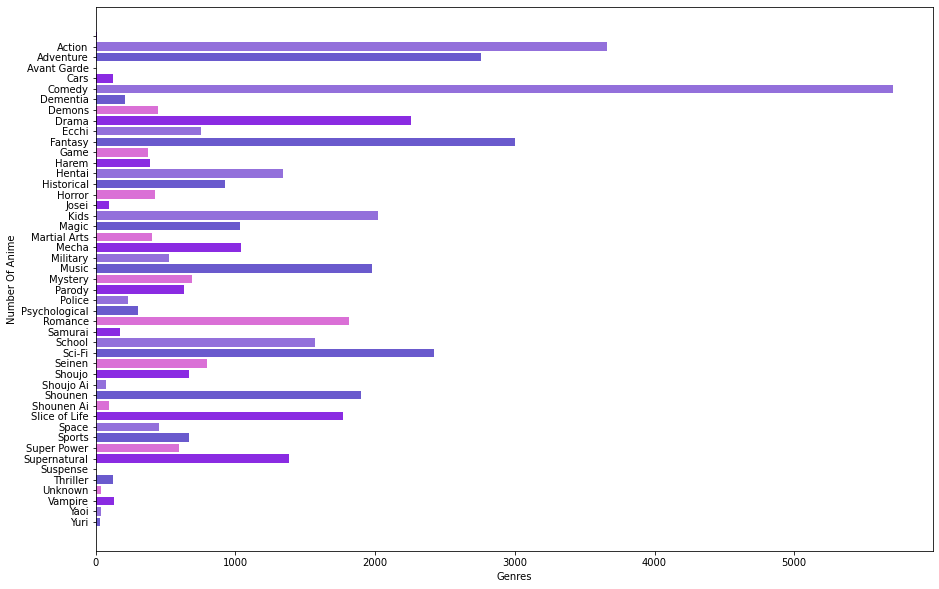

In [10]:
num_o_genre = genre_count.tolist()
num_o_genre.reverse()
expanded_genres.reverse()
fig = plt.figure(figsize=(15,10))
plt.barh(expanded_genres,num_o_genre,color=['slateblue','mediumpurple','blueviolet','orchid'])
plt.xlabel('Genres')
plt.ylabel('Number Of Anime')

## Different Type of Media

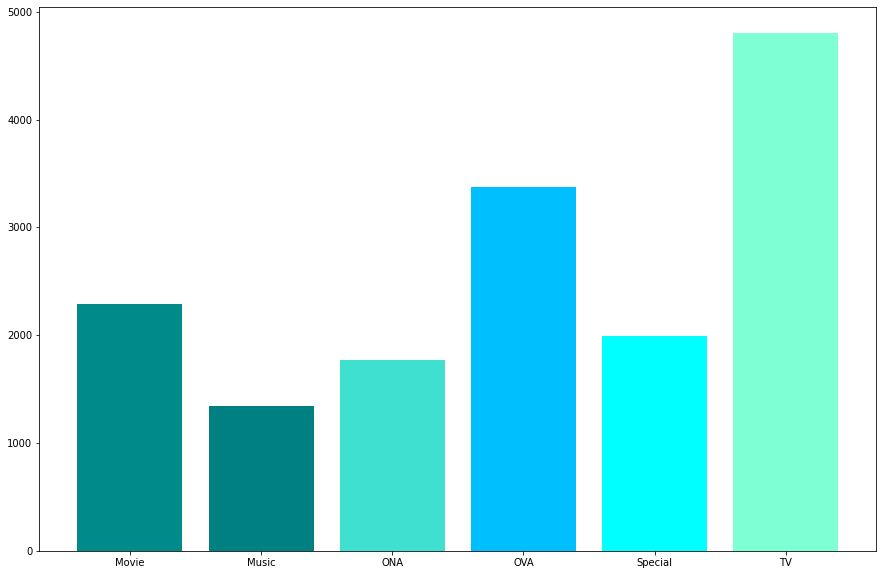

In [11]:
## Type of media
num_o_type = type_count.tolist()
name_o_type = ['Movie','Music','ONA','OVA','Special','TV']
fig2 = plt.figure(figsize=(15,10))
plt.bar(name_o_type,num_o_type,color=['darkcyan','teal','turquoise','deepskyblue','aqua','aquamarine'])
plt.show()

## Histogram Showing the frequency of Score for Animes

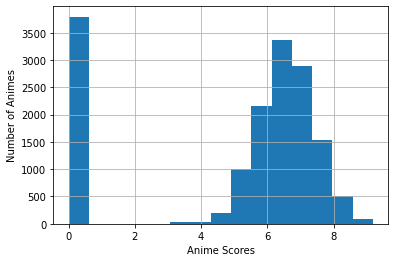

In [12]:
histogram_df = binarized_combined_dataset

histogram_df[['Score']] = histogram_df[['Score']].replace('Unknown', np.nan)

histogram_df = histogram_df.fillna(0)

histogram_df['Score'] = pd.to_numeric(histogram_df['Score'])

histogram_df["Score"].hist(bins=15)

plt.ylabel('Number of Animes')
plt.xlabel('Anime Scores')

plt.show()

# Creating our models
models showcased:
- linear regression
- KNN (k nearest neighbors)
- random forest

## K Nearest Neighbors

### Choosing k for KNN


       MAL_ID                                               Name Score   Type  \
8379    23187  Chamebou Shin Gachou: Nomi Fuufu Shikaeshi no ...   0.0  Movie   
6079    10742                             Saru to Kani no Gassen  5.12  Movie   
4580     6654                                    Namakura Gatana  5.55  Movie   
8637    24573                                     Neko to Nezumi   0.0  Movie   
8377    23183                                       Itazura Post   0.0  Movie   
...       ...                                                ...   ...    ...   
15555   49722                  Karakai Jouzu no Takagi-san Movie   0.0  Movie   
15562   49845  Tongari Atama no Gonta: Futatsu no Namae wo Ik...   0.0  Movie   
15560   49827          Mobile Suit Gundam: Cucuruz Doan's Island   0.0  Movie   
15552   41567                Isekai Quartet Movie: Another World   0.0  Movie   
15533   50953                Bastard!! Ankoku no Hakaishin (ONA)   0.0    ONA   

           Aired    Premier

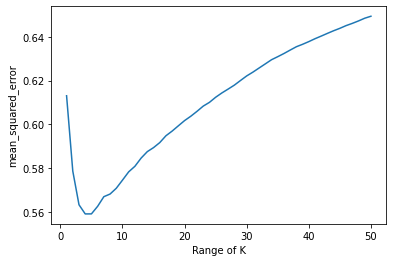

best k:  4


In [13]:

knn_df = binarized_combined_dataset
print(knn_df)
knn_df[['Ranked']] = knn_df[['Ranked']].replace('Unknown', np.nan)
knn_df[['Popularity']] = knn_df[['Popularity']].replace('Unknown', np.nan)
knn_df[['Score']] = knn_df[['Score']].replace('Unknown', np.nan)

knn_df = knn_df.fillna(0)

knn_df['Score'] = pd.to_numeric(knn_df['Score'])

X = knn_df[['Ranked','Popularity','Members', 'Action',
       'Adventure', 'Avant Garde', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical',
       'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military',
       'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance',
       'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai',
       'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi',
       'Yuri']]

y = knn_df['Score']

knn = neighbors.KNeighborsRegressor(n_neighbors=14, weights='uniform')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


knn.fit(X_train, y_train)

y_pred = cross_val_predict(knn, X, y, cv=5)
error = []
for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, X, y, cv=5)
    error.append(sqrt(mean_squared_error(y,y_pred)))


lowest_mse = error.index(min(error))+1
plt.plot(range(1,51),error)
plt.ylabel('mean_squared_error')
plt.xlabel('Range of K')
plt.show()

print("best k: ", lowest_mse)
  

In [14]:
knn_df[['Ranked']] = knn_df[['Ranked']].replace('Unknown', np.nan)
knn_df[['Popularity']] = knn_df[['Popularity']].replace('Unknown', np.nan)
knn_df[['Score']] = knn_df[['Score']].replace('Unknown', np.nan)

knn_df = knn_df.fillna(0)

knn_df['Score'] = pd.to_numeric(knn_df['Score'])

X = knn_df[['Ranked','Popularity','Members', 'Action',
       'Adventure', 'Avant Garde', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical',
       'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military',
       'Music', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance',
       'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai',
       'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi',
       'Yuri', 'PremieredLabelEncoded']]

y = knn_df['Score']


knn = neighbors.KNeighborsRegressor(n_neighbors=lowest_mse, weights='uniform')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


knn.fit(X_train, y_train)

y_pred = cross_val_predict(knn, X, y, cv=5)
print('mean_squared_error', sqrt(mean_squared_error(y,y_pred)))

print("Test set predictions:\n{}".format(knn.predict(X_test)))
print("Test set R^2: {:.2f}".format(knn.score(X_test, y_test)))


mean_squared_error 0.5529496944962944
Test set predictions:
[5.4725 7.815  6.315  ... 6.5825 6.285  0.    ]
Test set R^2: 0.96


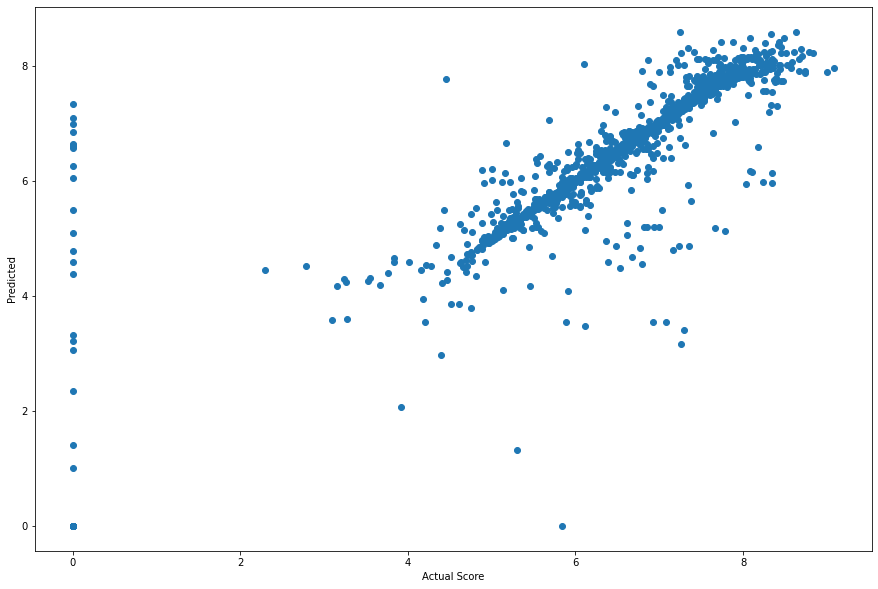

In [15]:
y_predicted = knn.predict(X_test)
y_predicted = y_predicted.astype(float)
actual_scores = y_test.astype(float)
fig = plt.figure(figsize=(15,10))
plt.scatter(actual_scores,y_predicted)
plt.xlabel('Actual Score')
plt.ylabel('Predicted')
plt.show()

## Linear Regression

In [16]:
#one hot encode type and studios
mlb = MultiLabelBinarizer()
binarized_combined_dataset_copy = binarized_combined_dataset
binarized_combined_dataset_copy = binarized_combined_dataset_copy.fillna(0)
binarized_combined_dataset_copy['Type'] = mlb.fit_transform(binarized_combined_dataset_copy['Type'])
binarized_combined_dataset_copy['Studios'] = mlb.fit_transform(binarized_combined_dataset_copy['Studios'])
binarized_combined_dataset_copy = binarized_combined_dataset_copy.drop(binarized_combined_dataset_copy[binarized_combined_dataset_copy['Score'].astype(float) <= 0].index)
# binarized_combined_dataset_copy.loc[binarized_combined_dataset_copy['Score'].astype(float) <= 0, 'Score'] = binarized_combined_dataset_copy['Score'].astype(float).mean()


In [17]:
#create the model
regr = LinearRegression()
Y = binarized_combined_dataset_copy['Score']

binarized_combined_dataset_copy.drop(inplace=True, columns=['Favorites', 'Completed', '','Name', 'MAL_ID', 'Aired', 'Premiered', 'Producers', 'Rating', 'Score'])
binarized_combined_dataset_copy['Ranked'].replace({'Unknown' : 0}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(binarized_combined_dataset_copy, Y, train_size=0.8, test_size=0.2)

print(binarized_combined_dataset_copy)
regr.fit(X_train, y_train)
results = regr.predict(X_test)
r2_acc = r2_score(y_test, results)
mse_error = mean_squared_error(y_test, results)
mae_error = mean_absolute_error(y_test, results)
print('r2_score: ', r2_acc)
print('mse_error: ', mse_error)
print('mae_error: ', mae_error)



       Type  Studios   Ranked  Popularity  Members  Watching  On-Hold  \
6079      0        0  10458.0     11508.0      646      21.0     16.0   
4580      0        0   9555.0      6074.0     5886      54.0     28.0   
7494      0        0  10544.0     10964.0      798      25.0     21.0   
6083      0        0   9216.0     12226.0      483      30.0     24.0   
4860      0        0  10821.0      8898.0     1951      29.0     12.0   
...     ...      ...      ...         ...      ...       ...      ...   
15466     0        1        0         0.0   103313       0.0      0.0   
15496     0        0        0         0.0     5308       0.0      0.0   
15462     0        1        0         0.0   128238       0.0      0.0   
15488     0        1        0         0.0    16218       0.0      0.0   
15481     0        1        0         0.0    24831       0.0      0.0   

       Dropped  Plan to Watch  Action  ...  Sports  Super Power  Supernatural  \
6079      86.0          157.0       0  ...

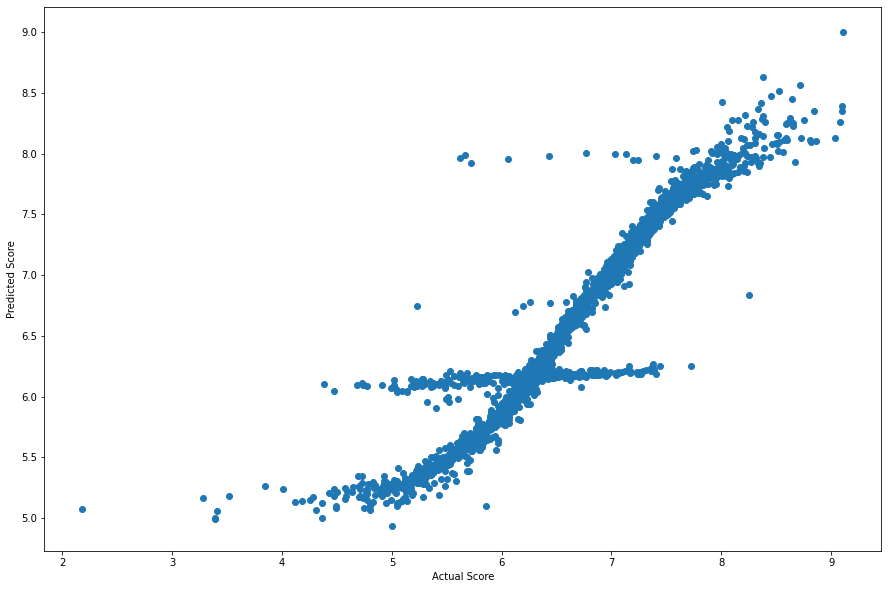

In [18]:
fig = plt.figure(figsize=(15,10))
plt.scatter(y_test.astype(float),results.astype(float))
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()



## Random Forest

In [38]:
type_bin = pd.get_dummies(combined_dataset['Type'], prefix='Type')
studios_bin = pd.get_dummies(combined_dataset['Studios'], prefix='Studio')

In [20]:
test= binarized_combined_dataset.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch'])
print(test.columns)

Index(['Score', 'Members', 'Action', 'Adventure', 'Avant Garde', 'Cars',
       'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game',
       'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Suspense', 'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri',
       'PremieredLabelEncoded'],
      dtype='object')


### Testing Singular Features
1. Members
2. Genres
3. Types

In [21]:
RF_Model = RandomForestRegressor()
members_only_tree = binarized_combined_dataset
members_only_tree = members_only_tree.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Action', 'Adventure', 'Avant Garde', 'Cars',
       'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game',
       'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Suspense', 'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri',
       'PremieredLabelEncoded'])
members_only_tree = members_only_tree.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(
    members_only_tree.drop(['Score'], axis='columns'), combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))

0.8625706238698004
0.010151692894960429


In [22]:
RF_Model = RandomForestRegressor()
bin_genre_tree = binarized_combined_dataset
bin_genre_tree = bin_genre_tree.drop(
    columns=['','Members','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios','Premiered', 'Studios','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch'])

X_train, X_test, Y_train, Y_test = train_test_split(
    bin_genre_tree.drop(['Score'], axis='columns'), combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))

0.6998920643149458
0.029545138594511244


In [23]:
RF_Model = RandomForestRegressor()
type_only_tree = pd.concat([binarized_combined_dataset, type_bin], axis='columns')
type_only_tree = type_only_tree.drop(
    columns=['','Members','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Action', 'Adventure', 'Avant Garde', 'Cars',
       'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game',
       'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Suspense', 'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri',
       'PremieredLabelEncoded','Popularity', 'Favorites', 'Watching', 'Completed', 'On-Hold',
       'Dropped', 'Plan to Watch'])
type_only_tree = type_only_tree.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(
    type_only_tree.drop(['Score'], axis='columns'), combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))

0.08818960400692799
0.0926305734549745


In [39]:
RF_Model = RandomForestRegressor()
studio_only_df = pd.concat([binarized_combined_dataset, studios_bin], axis='columns')
studio_only_df = studio_only_df.drop(
    columns=['','Members','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Action', 'Adventure', 'Avant Garde', 'Cars',
       'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game',
       'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Suspense', 'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri',
       'PremieredLabelEncoded','Popularity', 'Favorites', 'Watching', 'Completed', 'On-Hold',
       'Dropped', 'Plan to Watch','Studio_Unknown'])

X_train, X_test, Y_train, Y_test = train_test_split(
    studio_only_df.drop(['Score'], axis='columns'), combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))

0.3544913500305904
0.2597411132334051


### Testing Combined Features
seeing how well combination features fair in terms of score

#### Only Genres Binarized

In [28]:
RF_Model = RandomForestRegressor()
base_tree_df = binarized_combined_dataset
base_tree_df = base_tree_df.drop(
    columns=['Score','','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch',
       'PremieredLabelEncoded'])
base_tree_df = base_tree_df.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(base_tree_df, combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))

0.8128926372036995
-0.1385105274717553


#### Types and Genres Binarized

0.9701610225266577
0.8039108542768609


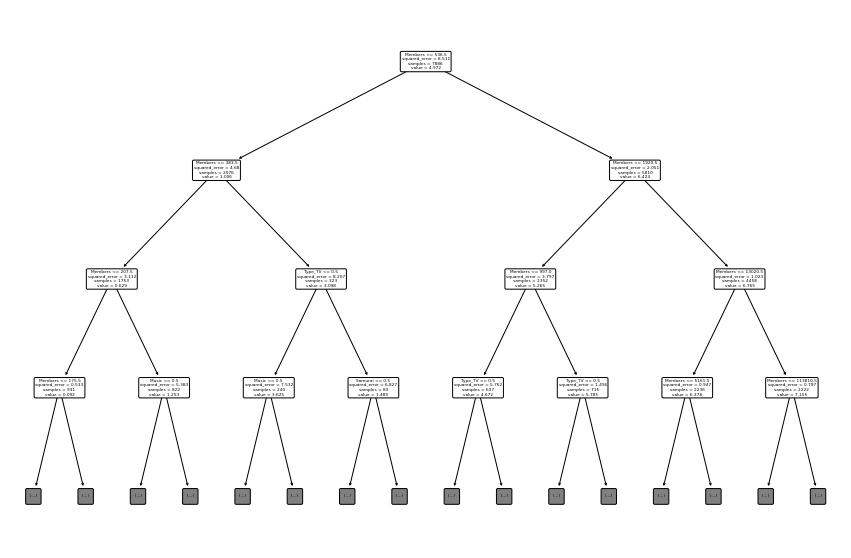

In [29]:
RF_Model = RandomForestRegressor()
GT_tree_df = pd.concat([binarized_combined_dataset, type_bin], axis='columns')

GT_tree_df = GT_tree_df.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch','PremieredLabelEncoded','Score'])
GT_tree_df = GT_tree_df.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(GT_tree_df, combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))

fig = plt.figure(figsize=(15, 10))
plot_tree(RF_Model.estimators_[9],max_depth=3, 
          feature_names=GT_tree_df.columns, 
          rounded=True)

plt.show()

#### Everything Binaraized/Encoded

0.9783852230811196
0.8419229410907123
1.3719733714184794


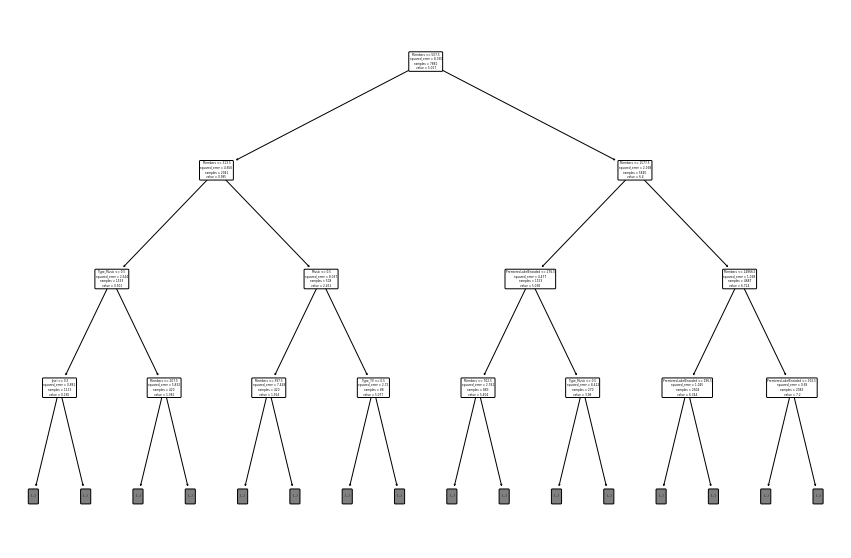

In [30]:

# Doing the actual model (Random Forest Regression)
RF_Model = RandomForestRegressor()

## creating a dataset that has binarized type and studios
tree_df = pd.concat([binarized_combined_dataset, type_bin], axis='columns')
tree_df = pd.concat([tree_df, studios_bin], axis='columns')

tree_df = tree_df.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Studio_Unknown','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch','Score'])
tree_df = tree_df.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(tree_df, combined_dataset['Score'], test_size=0.2)

RF_Model.fit(X_train, Y_train)
y_predicted = RF_Model.predict(X_test)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))
print(mean_squared_error(Y_test, y_predicted))

fig = plt.figure(figsize=(15, 10))
plot_tree(RF_Model.estimators_[9],max_depth=3, 
          feature_names=tree_df.columns, 
          rounded=True)

plt.show()

##### Graphing how well the model did

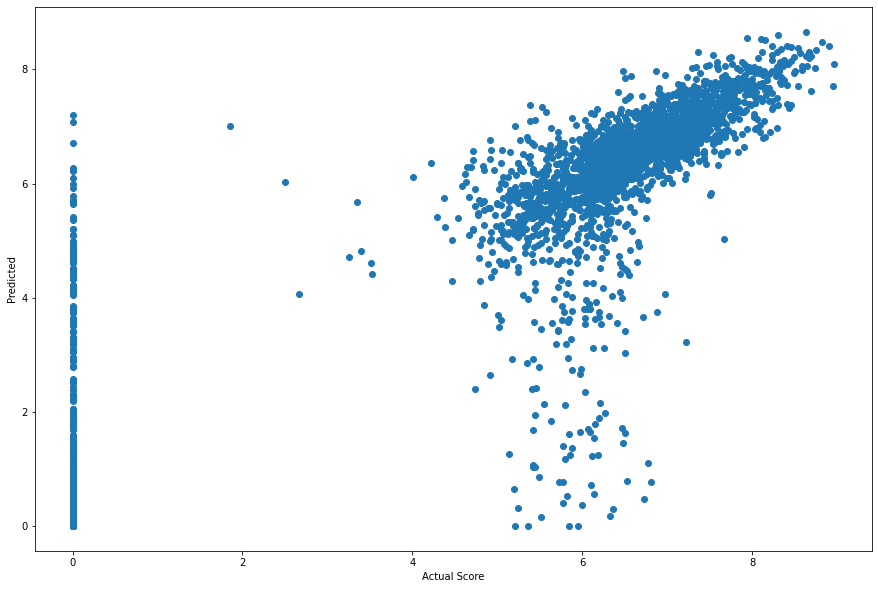

In [33]:
y_predicted = RF_Model.predict(X_test)
y_predicted = y_predicted.astype(float)
actual_scores = Y_test.astype(float)
fig = plt.figure(figsize=(15,10))
plt.scatter(actual_scores,y_predicted)
plt.xlabel('Actual Score')
plt.ylabel('Predicted')
plt.show()

##### Predicting An Actual Show


In [34]:
dragon_ball_df = pd.concat([binarized_combined_dataset, type_bin], axis='columns')
dragon_ball_df = pd.concat([dragon_ball_df, studios_bin], axis='columns')
dragon_ball_df = dragon_ball_df.loc[dragon_ball_df['Name']=='Dragon Ball']
db_score = dragon_ball_df['Score']
dragon_ball_df = dragon_ball_df.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Studio_Unknown','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch','Score'])
predicted_score = RF_Model.predict(dragon_ball_df)
print('Actual Score: ', db_score)
print('Predicted Score: ',predicted_score)

Actual Score:  200    8.0
Name: Score, dtype: object
Predicted Score:  [8.0559]


#### Optimization
droppig zeros inside of score column

0.9505992255976262
0.650473510001458
0.2526069287413224


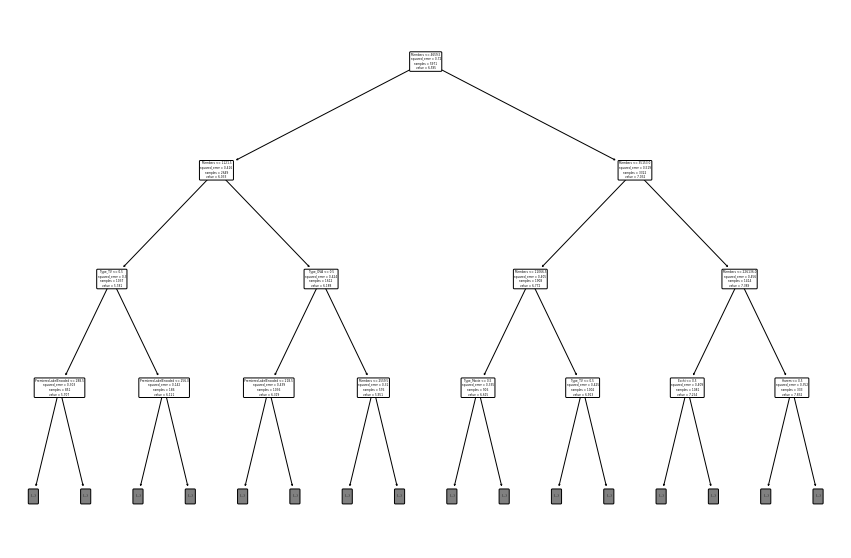

In [35]:
# Doing the actual model (Random Forest Regression)
RF_Model = RandomForestRegressor()

## creating a dataset that has binarized type and studios
optimized_tree_df = pd.concat([binarized_combined_dataset, type_bin], axis='columns')
optimized_tree_df = pd.concat([optimized_tree_df, studios_bin], axis='columns')
optimized_tree_df = optimized_tree_df.drop(optimized_tree_df[optimized_tree_df['Score'].astype(float) <= 0].index)
scores = optimized_tree_df['Score']
optimized_tree_df = optimized_tree_df.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Studio_Unknown','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch','Score'])
optimized_tree_df = optimized_tree_df.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(optimized_tree_df, scores, test_size=0.2)

RF_Model.fit(X_train, Y_train)
y_predicted = RF_Model.predict(X_test)
print(RF_Model.score(X_train, Y_train))
print(RF_Model.score(X_test, Y_test))
print(mean_squared_error(Y_test, y_predicted))

fig = plt.figure(figsize=(15, 10))
plot_tree(RF_Model.estimators_[9],max_depth=3, 
          feature_names=optimized_tree_df.columns, 
          rounded=True)

plt.show()

##### Graphing

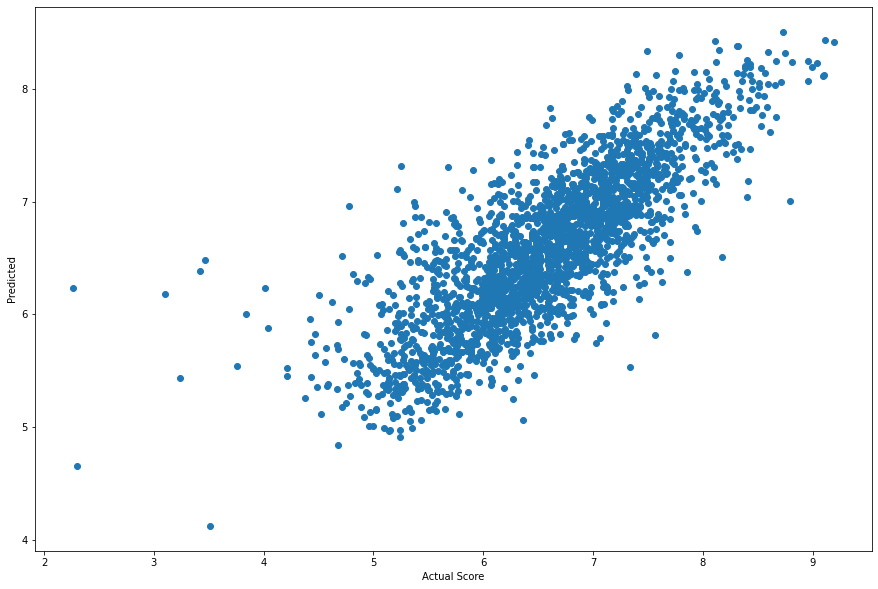

In [36]:
y_predicted = RF_Model.predict(X_test)
y_predicted = y_predicted.astype(float)
actual_scores = Y_test.astype(float)
fig = plt.figure(figsize=(15,10))
plt.scatter(actual_scores,y_predicted)
plt.xlabel('Actual Score')
plt.ylabel('Predicted')
plt.show()

##### Predicting the Show again

In [37]:
dragon_ball_df = pd.concat([binarized_combined_dataset, type_bin], axis='columns')
dragon_ball_df = pd.concat([dragon_ball_df, studios_bin], axis='columns')
dragon_ball_df = dragon_ball_df.loc[dragon_ball_df['Name']=='Dragon Ball']
db_score = dragon_ball_df['Score']
dragon_ball_df = dragon_ball_df.drop(
    columns=['','Aired', 'Name', 'MAL_ID', 'Producers', 'Rating', 'Ranked', 'Type', 'Premiered', 'Studios', 'Studio_Unknown','Popularity','Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Plan to Watch','Score'])
predicted_score = RF_Model.predict(dragon_ball_df)
print('Actual Score: ', db_score)
print('Predicted Score: ',predicted_score)

Actual Score:  200    8.0
Name: Score, dtype: object
Predicted Score:  [8.0886]
